# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.374366
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *The probabilistic interperation of softmax sets the sum inside the log function as the probability P(y_i|x_i, W). Since our W is randomly chosen, this probability should be about 10% (dumb luck chance).*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print ('')

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.933985 analytic: 0.933985, relative error: 2.900866e-08
numerical: 0.380040 analytic: 0.380040, relative error: 5.897266e-08
numerical: 1.757946 analytic: 1.757946, relative error: 1.794009e-08
numerical: -1.219232 analytic: -1.219232, relative error: 2.850973e-08
numerical: -1.827970 analytic: -1.827970, relative error: 2.590779e-10
numerical: -0.415465 analytic: -0.415465, relative error: 1.623855e-09
numerical: -0.437760 analytic: -0.437760, relative error: 2.187374e-08
numerical: -0.554661 analytic: -0.554661, relative error: 8.354870e-08
numerical: 2.916272 analytic: 2.916272, relative error: 1.018770e-08
numerical: 1.971572 analytic: 1.971572, relative error: 1.334234e-08

numerical: -0.154855 analytic: -0.154855, relative error: 5.577431e-08
numerical: -0.474209 analytic: -0.474209, relative error: 5.358440e-09
numerical: -2.168503 analytic: -2.168503, relative error: 1.229991e-08
numerical: -1.263509 analytic: -1.263509, relative error: 3.284469e-08
numerical: 0.39

In [18]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
print(grad_naive - grad_vectorized).mean()

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.374366e+00 computed in 0.144776s
vectorized loss: 2.374366e+00 computed in 0.054780s
1.10427825908e-17
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

best validation accuracy achieved during cross-validation: -1.000000


In [19]:
results = {}
best_smax = Softmax(W = np.random.randn(3073, 10) * 0.0001)

In [24]:
from cs231n.classifiers import Softmax
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-6]
#regularization_strengths = [5e4, 1e5]
learning_rates = [2e-7]
regularization_strengths = [5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

best_val = -1  
#hyperparam = np.dstack(np.meshgrid(learning_rates, regularization_strengths)).reshape(-1, 2)
hyperparam = [[1e-7, 5e2], [1e-7, 8e2]]

for [lr, reg] in hyperparam:
    smax = Softmax(W=np.copy(best_smax.W))
    smax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)
    y_train_pred = smax.predict(X_train)
    y_val_pred = smax.predict(X_val)
    results[(lr, reg)] = [np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred), smax]
    print('')


best_val, best_smax = np.array(results.values())[np.argmax(np.array(results.values())[:, 1]), [1, 2]]

#best_svm = results.keys()[np.argmax(np.array(results.values())[:, 1])][2]
#print (np.argmax(np.array(results.values())[:, 1]))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy, svm = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1000: loss 1.888160
iteration 100 / 1000: loss 1.900018
iteration 200 / 1000: loss 1.775349
iteration 300 / 1000: loss 1.755832
iteration 400 / 1000: loss 1.842114
iteration 500 / 1000: loss 1.774603
iteration 600 / 1000: loss 1.791079
iteration 700 / 1000: loss 1.784522
iteration 800 / 1000: loss 1.713647
iteration 900 / 1000: loss 1.808686

iteration 0 / 1000: loss 1.755884
iteration 100 / 1000: loss 1.707595
iteration 200 / 1000: loss 1.790196
iteration 300 / 1000: loss 1.814079
iteration 400 / 1000: loss 1.834924
iteration 500 / 1000: loss 1.777284
iteration 600 / 1000: loss 1.752998
iteration 700 / 1000: loss 1.749881
iteration 800 / 1000: loss 1.861039
iteration 900 / 1000: loss 1.804027

lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.398531 val accuracy: 0.401000
lr 1.000000e-07 reg 8.000000e+02 train accuracy: 0.398857 val accuracy: 0.404000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.391490 val accuracy: 0.403000
lr 1.000000e-07 reg 5.000000e+03 train 

In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_smax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.389000


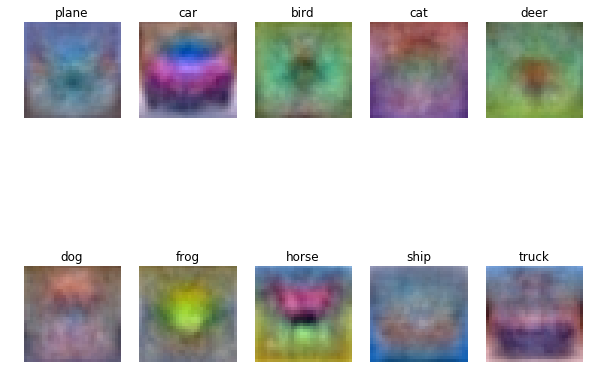

In [28]:
# Visualize the learned weights for each class
w = best_smax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])